In [1]:
import torchvision.transforms as transforms
import torchvision
import torch 

# Load test dataset:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize with mean 0.5 and standard deviation 0.5
    transforms.Normalize((0.5,), (0.5,)) 
])

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

Original tensor shape: torch.Size([1, 28, 28])
Original value range:  [-1.0, 1.0]
Display shape: torch.Size([28, 28])
Display value range: [0.0, 1.0]


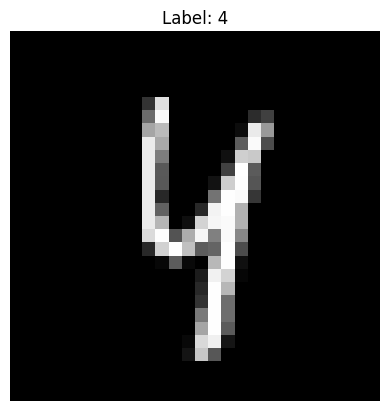

In [2]:
import matplotlib.pyplot as plt
import random

# Define the denormalize function
def denormalize(tensor):
    return (tensor + 1) / 2

# Get a random image
idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[idx]

print(f"Original tensor shape: {image.shape}")
print(f"Original value range:  [{image.min()}, {image.max()}]")

image_denorm = denormalize(image)

# 4. Remove the channel dimension (1, 28, 28) -> (28, 28)
#    matplotlib.imshow() needs a 2D array for grayscale.
image_display = image_denorm.squeeze() 

print(f"Display shape: {image_display.shape}")
print(f"Display value range: [{image_display.min()}, {image_display.max()}]")

# Plot the image
plt.imshow(image_display, cmap='gray') # 'cmap' is crucial for grayscale
plt.title(f"Label: {label}")
plt.axis('off') # Hide the axes
plt.show()


In [3]:
def plot_image_on_grid(ax, xt, row, img_idx, name, t):
    """Helper function to plot a single image on the matplotlib grid."""
    
    # Move to CPU for plotting
    img_cpu = xt.cpu() 
    
    # Denormalize, clamp, and squeeze
    img_display = denormalize(img_cpu).clamp(0, 1).squeeze()

    # Display the image
    ax.imshow(img_display, cmap='gray')
    ax.set_axis_off()
    
    # Add scheduler name as Y-label to the first column
    if img_idx == 0:
        ax.text(-0.2, 0.5, name, transform=ax.transAxes, 
                fontsize=10, va='center', ha='right', rotation=0)

    # Add time step as Title to the first row
    if row == 0:
        ax.set_title(f"t={t}", fontsize=11, pad=10)
    
    return img_idx + 1 # Return the incremented index

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x0 = image.unsqueeze(0).to(device) # x0 is the clean, original image
print(f"Using device: {device}")
print(f"Displaying noise process for a random digit: {label}")

Using device: cuda
Displaying noise process for a random digit: 4


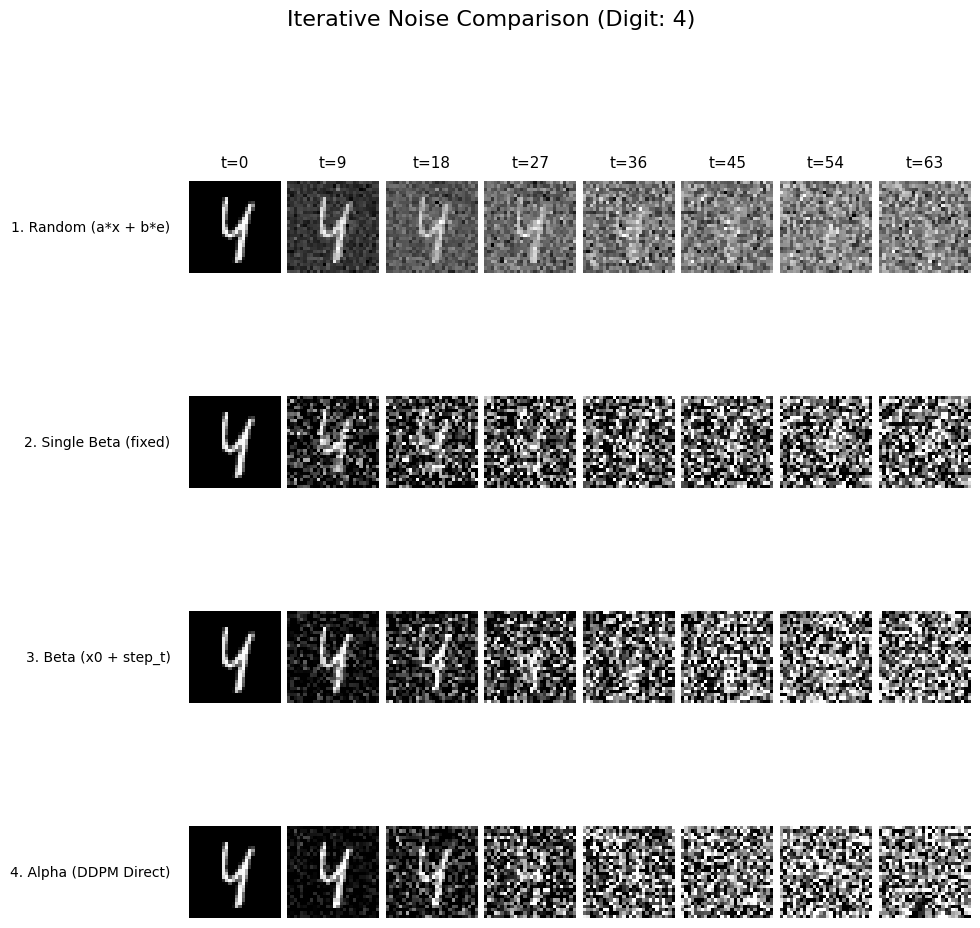

In [7]:
from utils.scheduler import Random_NoiseScheduler, SingleBeta_NoiseScheduler, Beta_NoiseScheduler, Alpha_NoiseScheduler
# DDPM Beta Schedule
BETA_START = 1e-4
BETA_END = 0.02 # Use 0.02 for a more gradual alpha process
    
# Random Noise Params
A_PARAM = 0.95
B_PARAM = 0.05
    
# Single Beta Param
SINGLE_BETA = 0.05

# NUM of steps
T=64

schedulers = {
        "1. Random (a*x + b*e)": Random_NoiseScheduler(a=A_PARAM, b=B_PARAM),
        "2. Single Beta (fixed)": SingleBeta_NoiseScheduler(beta=SINGLE_BETA),
        "3. Beta (x0 + step_t)": Beta_NoiseScheduler(steps=T, beta_start=BETA_START, beta_end=BETA_END*10, device=device), 
        "4. Alpha (DDPM Direct)": Alpha_NoiseScheduler(steps=T, beta_start=BETA_START, beta_end=BETA_END, device=device)
    }


num_display = 8
t_steps = torch.linspace(0, T - 1, num_display, dtype=torch.long)

fig, axes = plt.subplots(4, num_display, figsize=(10, 10))

for row, (name, scheduler) in enumerate(schedulers.items()):
    xt = x0.clone() # Start with the clean image at t=0
    img_idx = 0 # Index for which column to plot in
    for t in range(T):
        if t in t_steps:
            ax = axes[row, img_idx] # Get the correct subplot
            
            # Call the new helper function to do the plotting
            img_idx = plot_image_on_grid(ax, xt, row, img_idx, name, t)

        xt = scheduler.add_noise(xt, t)

plt.suptitle(f"Iterative Noise Comparison (Digit: {label})", fontsize=16, y=1.02)
plt.tight_layout(pad=1.5, h_pad=2.0, w_pad=0.5) # Adjust padding
plt.show()
